# Exploration_15

## 1. Recommend

### 1.1 Module

In [1]:
! pip install implicit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.5 MB 7.8 MB/s 


In [2]:
import os
import json
import scipy
import implicit
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares

from google.colab import drive

In [3]:
drive.mount('/gdrive')

Mounted at /gdrive


### 1.2 Function

#### 1.2.1 id_to_title

- movie_id를 넣으면 title로 반환해줍니다.

In [4]:
def id_to_title(id):
    return movies['title'][movies['movie_id']==id].values[0]

#### 1.2.2 title_to_id

- 반대로 title을 넣으면 movie_id로 반환해줍니다.

In [5]:
def title_to_id(title):
    return movies['movie_id'][movies['title']==title].values[0].item()

#### 1.2.3 similar_movie

- 비슷한 영화를 찾아냅니다.

In [6]:
def similar_movies(title_name, model_name, find_num):
    favorite_movie_id = title_to_id(title_name)
    my_movie_id = movie_to_idx[favorite_movie_id]
    similar_movies = model_name.similar_items(my_movie_id, N=(find_num))
    
    idx_to_movie = {v:k for k,v in movie_to_idx.items()}
    my_similar = [idx_to_movie[i] for i in similar_movies[0]]

    mylist = [id_to_title(i) for i in my_similar]
    print(*mylist[:], sep='\n') 

#### 1.2.4 recommended_movies

- listing을 토대로 영화를 추천합니다.

In [7]:
def recommended_movies(user_name, model_name, find_num):
    user = user_to_idx[user_name]
    movie_recommended = model_name.recommend(user, csr_data[user], N=find_num, filter_already_liked_items=True)
    
    idx_to_movie = {v:k for k,v in movie_to_idx.items()}
    my_recommended = [idx_to_movie[i] for i in movie_recommended[0]]
    
    mylist_2 = [id_to_title(i) for i in my_recommended]
    print(*mylist_2[:], sep='\n')

#### 1.2.5 explain_moives

- 영화가 추천에 기여한 정도를 나타냅니다.

In [8]:
def explain_movies(movie_title, model_name):
    explain_movie = movie_title
    explain_movie = title_to_id(explain_movie)
    explain_movie = movie_to_idx[explain_movie]
    explain = model_name.explain(user, csr_data, itemid=explain_movie)
    print(explain[0])
    print(explain[1])

### 1.3 Data

#### 1.3.1 Data load

- ratings.dat의 데이터를 불러옵니다.
- column name이 없으므로 name까지 지정해줍니다.

In [9]:
rating_file_path='/gdrive/My Drive/Colab Notebooks/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python')
orginal_data_size = len(ratings)
print(ratings.shape)
ratings.head(5)

(1000209, 4)


,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


- movies.dat의 데이터를 불러옵니다.
- 마찬가지로 column name이 필요합니다.

In [10]:
movie_file_path='/gdrive/My Drive/Colab Notebooks/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding = 'ISO-8859-1')
print(movies.shape)
movies.head()

(3883, 3)


,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


#### 1.3.2 Preprocess

- 약간의 전처리가 필요합니다.
- indexing 과정이 필요하므로 merge로 한 파일에서 관리합니다.

In [11]:
ratings = pd.merge(ratings,movies, how='outer',on='movie_id') 
orginal_data_size = len(ratings)

- 데이터를 다루기 쉽도록 rating 3이상만 남겨둡니다.

In [12]:
# 3점 이상만 남깁니다.
ratings = ratings[ratings['rating']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000386, filtered_data_size: 836478
Ratio of Remaining Data is 83.62%


- 파일의 이름은 ratings이고 column의 이름은 rating이라 겹치지는 않지만, 헷갈릴 수 있으니 count로 바꿔줍니다.

In [13]:
ratings.rename(columns={'rating':'count'}, inplace=True)

- 확인해봅니다.

In [14]:
ratings.head(5)

,user_id,movie_id,count,timestamp,title,genre
0,1.0,1193,5.0,978300760.0,One Flew Over the Cuckoo's Nest (1975),Drama
1,2.0,1193,5.0,978298413.0,One Flew Over the Cuckoo's Nest (1975),Drama
2,12.0,1193,4.0,978220179.0,One Flew Over the Cuckoo's Nest (1975),Drama
3,15.0,1193,4.0,978199279.0,One Flew Over the Cuckoo's Nest (1975),Drama
4,17.0,1193,5.0,978158471.0,One Flew Over the Cuckoo's Nest (1975),Drama


#### 1.3.3 Data check

- movies의 movie_id와 ratings의 movie_id를 비교해봅니다.

In [15]:
ratings['movie_id'].nunique()

3628

In [16]:
movies['movie_id'].nunique()

3883

- 위에서 count를 3 이상만 남겨서 차이가 나는 것 같습니다.
- 학습을 ratings로 해서 movies로 정보를 뽑아내는데는 문제 없을 것 같습니다.

- 위에서 만들어 놓은 id_to_title, title_to_id를 확인합니다.

In [17]:
id_to_title(260)

'Star Wars: Episode IV - A New Hope (1977)'

In [18]:
title_to_id('Star Wars: Episode IV - A New Hope (1977)')

260

- 잘 나옵니다.

In [19]:
ratings.head(10)

,user_id,movie_id,count,timestamp,title,genre
0,1.0,1193,5.0,978300760.0,One Flew Over the Cuckoo's Nest (1975),Drama
1,2.0,1193,5.0,978298413.0,One Flew Over the Cuckoo's Nest (1975),Drama
2,12.0,1193,4.0,978220179.0,One Flew Over the Cuckoo's Nest (1975),Drama
3,15.0,1193,4.0,978199279.0,One Flew Over the Cuckoo's Nest (1975),Drama
4,17.0,1193,5.0,978158471.0,One Flew Over the Cuckoo's Nest (1975),Drama
5,18.0,1193,4.0,978156168.0,One Flew Over the Cuckoo's Nest (1975),Drama
6,19.0,1193,5.0,982730936.0,One Flew Over the Cuckoo's Nest (1975),Drama
7,24.0,1193,5.0,978136709.0,One Flew Over the Cuckoo's Nest (1975),Drama
8,28.0,1193,3.0,978125194.0,One Flew Over the Cuckoo's Nest (1975),Drama
9,33.0,1193,5.0,978557765.0,One Flew Over the Cuckoo's Nest (1975),Drama


##### 1) ratings에 있는 유니크한 영화 개수

In [20]:
ratings['user_id'].nunique()

6039

##### 2) ratings에 있는 유니크한 사용자 수

In [21]:
ratings['movie_id'].nunique()

3628

##### 3) 가장 인기 있는 영화 30개

- 인기가 많다는 것은 많이 봤다는 것과 같으니 movie_id에 몇명의 user_id가 있는지 파악해서 sorting하면 될 것 같습니다.

In [22]:
ranking = ratings.groupby('movie_id')['user_id'].count()
ranking = ranking.sort_values(ascending=False).head(30)  

In [23]:
print(ranking)

movie_id
2858    3211
260     2910
1196    2885
1210    2716
2028    2561
589     2509
593     2498
1198    2473
1270    2460
2571    2434
480     2413
2762    2385
608     2371
110     2314
1580    2297
527     2257
1197    2252
2396    2213
1617    2210
318     2194
858     2167
1265    2121
1097    2102
2997    2066
2716    2051
296     2030
356     2022
1240    2019
1       2000
457     1941
Name: user_id, dtype: int64


- id 형태를 title로 바꿔줍니다.

In [24]:
for idx, i in zip(ranking.index, ranking.keys()):
    print(id_to_title(i))

American Beauty (1999)
Star Wars: Episode IV - A New Hope (1977)
Star Wars: Episode V - The Empire Strikes Back (1980)
Star Wars: Episode VI - Return of the Jedi (1983)
Saving Private Ryan (1998)
Terminator 2: Judgment Day (1991)
Silence of the Lambs, The (1991)
Raiders of the Lost Ark (1981)
Back to the Future (1985)
Matrix, The (1999)
Jurassic Park (1993)
Sixth Sense, The (1999)
Fargo (1996)
Braveheart (1995)
Men in Black (1997)
Schindler's List (1993)
Princess Bride, The (1987)
Shakespeare in Love (1998)
L.A. Confidential (1997)
Shawshank Redemption, The (1994)
Godfather, The (1972)
Groundhog Day (1993)
E.T. the Extra-Terrestrial (1982)
Being John Malkovich (1999)
Ghostbusters (1984)
Pulp Fiction (1994)
Forrest Gump (1994)
Terminator, The (1984)
Toy Story (1995)
Fugitive, The (1993)


- 역시 모두가 아는 유명한 작품들입니다.

### 1.4 Model(Default)

In [25]:
# favorite_title 5개 생성
favorite_title = ['Usual Suspects, The (1995)',
                  'Armageddon (1998)',
                  'Home Alone 2: Lost in New York (1992)',
                  'Shawshank Redemption, The (1994)',
                  'Forrest Gump (1994)']

# favorite_title -> favorite_id 변환 
favorite_id = [title_to_id(i) for i in favorite_title]

# user_id = 'JB', 5점 부여 
my_list = pd.DataFrame({'user_id': ['JB']*5, 'movie_id': favorite_id, 'count':[5]*5, 'timestamp':[0]*5})

if not ratings.isin({'user_id':['JB']})['user_id'].any():  # user_id에 동일 id가 있는지 확인 후 추가
    ratings = ratings.append(my_list)                            

In [26]:
ratings.tail(10) 

,user_id,movie_id,count,timestamp,title,genre
1000203,5556.0,2198,3.0,959445515.0,Modulations (1998),Documentary
1000204,5949.0,2198,5.0,958846401.0,Modulations (1998),Documentary
1000205,5675.0,2703,3.0,976029116.0,Broken Vessels (1998),Drama
1000207,5851.0,3607,5.0,957756608.0,One Little Indian (1973),Comedy|Drama|Western
1000208,5938.0,2909,4.0,957273353.0,"Five Wives, Three Secretaries and Me (1998)",Documentary
0,JB,50,5.0,0.0,NaN,NaN
1,JB,1917,5.0,0.0,NaN,NaN
2,JB,2953,5.0,0.0,NaN,NaN
3,JB,318,5.0,0.0,NaN,NaN
4,JB,356,5.0,0.0,NaN,NaN


- user_id에 이름을 넣었으므로 고유한 값으로 indexing해주는 코드가 필요합니다.

In [27]:
# 고유한 유저, 영화를 찾아내는 코드
user_unique = ratings['user_id'].unique()
movie_unique = ratings['movie_id'].unique()

# 유저, 영화 indexing 하는 코드
user_to_idx = {v:k for k,v in enumerate(user_unique)}
movie_to_idx = {v:k for k,v in enumerate(movie_unique)}

In [28]:
user_to_idx['JB']

6039

In [29]:
temp_user_data = ratings['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(ratings):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    ratings['user_id'] = temp_user_data   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

# artist_to_idx을 통해 movie_id 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_movie_data = ratings['movie_id'].map(movie_to_idx.get).dropna()
if len(temp_movie_data) == len(ratings):
    print('movie id column indexing OK!!')
    ratings['movie_id'] = temp_movie_data
else:
    print('movie id column indexing Fail!!')

user_id column indexing OK!!
movie id column indexing OK!!


In [30]:
ratings.tail(10)

,user_id,movie_id,count,timestamp,title,genre
1000203,1532,3624,3.0,959445515.0,Modulations (1998),Documentary
1000204,1649,3624,5.0,958846401.0,Modulations (1998),Documentary
1000205,1564,3625,3.0,976029116.0,Broken Vessels (1998),Drama
1000207,1621,3626,5.0,957756608.0,One Little Indian (1973),Comedy|Drama|Western
1000208,4159,3627,4.0,957273353.0,"Five Wives, Three Secretaries and Me (1998)",Documentary
0,6039,259,5.0,0.0,NaN,NaN
1,6039,133,5.0,0.0,NaN,NaN
2,6039,1091,5.0,0.0,NaN,NaN
3,6039,167,5.0,0.0,NaN,NaN
4,6039,171,5.0,0.0,NaN,NaN


- indexing 과정이 끝났습니다.  
다음으로 넘어갑니다.

- model에 넣어줄 csr_matrix를 만듭니다.

In [31]:
num_user = ratings['user_id'].nunique()
num_movie = ratings['movie_id'].nunique()

csr_data = csr_matrix((ratings['count'], (ratings['user_id'], ratings['movie_id'])), shape=(num_user, num_movie))
csr_data

<6040x3628 sparse matrix of type '<class 'numpy.float64'>'
	with 836483 stored elements in Compressed Sparse Row format>

- implicit 라이브러리에서 권장하는 환경설정이라고 합니다. 적용합니다.

In [9]:
# implicit 라이브러리에서 권장하는 환경설정
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

- default 값으로 하나 돌려봅니다.

In [33]:
als_model = AlternatingLeastSquares(factors=100, 
                                    regularization=0.01, 
                                    use_gpu=False, 
                                    iterations=20, 
                                    dtype=np.float32)

In [34]:
als_model.fit(csr_data)

  0%|          | 0/20 [00:00<?, ?it/s]

- 선호 목록에 추가한 Armageddon (1988)을 바탕으로 vector 값을 구해봅니다.

In [35]:
title_to_id('Armageddon (1998)')

1917

In [ ]:
JB, armageddon = user_to_idx['JB'], movie_to_idx[1917]
JB_vector, armageddon_vector = als_model.user_factors[JB], als_model.item_factors[armageddon]

In [ ]:
JB_vector

array([-4.44164008e-01, -4.02949452e-01,  1.86932296e-01, -2.13885517e-03,
        9.30703655e-02, -5.22963762e-01, -8.06503221e-02, -3.73859823e-01,
        3.41973931e-01,  5.21368146e-01,  2.38106519e-01, -3.88485283e-01,
        8.94590735e-01,  3.05407703e-01, -4.88455109e-02,  6.36280805e-04,
       -3.90047014e-01, -2.53223777e-01,  4.06845987e-01,  4.96083468e-01,
       -5.98426521e-01,  6.41442537e-01,  3.34863931e-01, -2.75767505e-01,
       -1.20277189e-01,  2.70341057e-02, -3.11001595e-02,  8.39486793e-02,
       -2.88106978e-01, -5.85094690e-01,  2.61917830e-01,  6.79334164e-01,
       -9.89315659e-02,  1.38793692e-01,  8.05179000e-01,  4.59750414e-01,
        7.42880553e-02,  1.08158481e+00,  3.00652146e-01,  2.67179459e-01,
        3.35243493e-01,  4.58197147e-01, -4.91448134e-01, -4.66690868e-01,
        1.35946751e-01, -3.44071895e-01,  3.91693741e-01,  2.25018904e-01,
        6.41256928e-01,  6.62416577e-01,  1.85720041e-01,  3.72925282e-01,
        1.53995492e-02, -

In [ ]:
armageddon_vector

array([ 0.00537482, -0.02362628,  0.03980782, -0.01414971,  0.01085595,
       -0.01338397, -0.01309045, -0.00879021,  0.02548362,  0.0047816 ,
        0.02119253,  0.00561666,  0.02033501,  0.0288763 ,  0.00182499,
        0.01010282, -0.00653202, -0.00719941,  0.01819043,  0.00459005,
       -0.0105461 ,  0.01031779,  0.01914252, -0.00876866,  0.0249516 ,
        0.00700519,  0.01409683,  0.02920774,  0.00147034, -0.001305  ,
       -0.01005778,  0.018454  , -0.00286368,  0.01137534,  0.02268412,
       -0.00784142, -0.01754197,  0.00242531,  0.01677715, -0.00357406,
        0.01016031,  0.00622253,  0.00279659, -0.01177014, -0.00308549,
        0.00167194,  0.02190161,  0.00288333,  0.00455669, -0.00609255,
        0.01945307, -0.00626901, -0.01353874, -0.00764308,  0.00517271,
       -0.00397776,  0.00346013, -0.00273255, -0.03417049,  0.02986474,
       -0.01890315,  0.01343407,  0.02622847,  0.00834461,  0.00860169,
        0.01297094,  0.00092974, -0.01957732, -0.04373533,  0.01

- 두 vector 값의 곱이 1에 가까운 vector를 기준으로 추천시스템을 비교해보려 합니다

In [ ]:
model_vector = np.dot(JB_vector, armageddon_vector)
print(model_vector)

0.26569548


- vector 값이 너무 작아 몇개의 hyper parameter를 바꿔가며 값을 확인합니다.

#### 1.4.1 Factor

- 우선 확인할 것은 factor입니다.
- 참고로 colab에서 오류가 발생해 다른 환경에서 돌리고 가져왔습니다.  
그래서 모델의 학습 시간 표기가 0으로 초기화 되어 있습니다.

##### 1) factors 500

- 기본 default는 100 이었습니다.  
5배 늘려 500부터 시작합니다.

In [36]:
als_model_1 = AlternatingLeastSquares(factors=500, 
                                    regularization=0.01, 
                                    use_gpu=False, 
                                    iterations=20, 
                                    dtype=np.float32)

In [37]:
als_model_1.fit(csr_data)

  0%|          | 0/20 [00:00<?, ?it/s]

In [38]:
JB, armageddon = user_to_idx['JB'], movie_to_idx[1917]
JB_vector_1, armageddon_vector_1 = als_model_1.user_factors[JB], als_model_1.item_factors[armageddon]

In [39]:
model_vector_1 = np.dot(JB_vector_1, armageddon_vector_1)
print(model_vector_1)

0.76836175


- vector 값이 1에 가까워지고 있습니다.  
  factor를 100으로 줬을 때 보다 시간은 더 걸리지만(약 30초), 매우 큰 상승폭을 보여줍니다.

##### 2) factors 1000

In [70]:
als_model_2 = AlternatingLeastSquares(factors=1000, 
                                    regularization=0.01, 
                                    use_gpu=False, 
                                    iterations=20, 
                                    dtype=np.float32)

In [71]:
als_model_2.fit(csr_data)

  0%|          | 0/20 [00:00<?, ?it/s]

In [72]:
JB, armageddon = user_to_idx['JB'], movie_to_idx[1917]
JB_vector_2, armageddon_vector_2 = als_model_2.user_factors[JB], als_model_2.item_factors[armageddon]

In [73]:
model_vector_2 = np.dot(JB_vector_2, armageddon_vector_2)
print(model_vector_2)

0.9441125


- 약 1분 10초의 시간이 걸립니다만, factor의 값이 vector에 큰 영향을 끼치는 것을 알 수 있습니다.

##### 3) factors 2000

In [40]:
als_model_3 = AlternatingLeastSquares(factors=2000, 
                                    regularization=0.01, 
                                    use_gpu=False, 
                                    iterations=20, 
                                    dtype=np.float32)

In [41]:
als_model_3.fit(csr_data)

  0%|          | 0/20 [00:00<?, ?it/s]

In [42]:
JB, armageddon = user_to_idx['JB'], movie_to_idx[1917]
JB_vector_3, armageddon_vector_3 = als_model_3.user_factors[JB], als_model_3.item_factors[armageddon]

In [43]:
model_vector_3 = np.dot(JB_vector_3, armageddon_vector_3)
print(model_vector_3)

0.99443215


- 약 3분 20초 소요됩니다.  
거의 1에 근접한 vector 값을 구할 수 있습니다.

In [ ]:
labels_1 = ['f_100', 'f_500', 'f_1000', 'f_2000']
values_1 = [model_vector, model_vector_1, model_vector_2, model_vector_3]

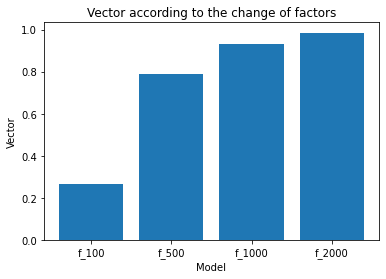

In [ ]:
plt.title('Vector according to the change of factors')
plt.xlabel('Model')
plt.ylabel('Vector')
plt.bar(range(len(values_1)), values_1)
plt.xticks(range(len(labels_1)), labels_1)
plt.show()

- 사실상 factor 값이 1000을 넘어서면 큰 의미는 없어 보입니다.

#### 1.4.2 Iteration

- iteration의 default는 20이었습니다.  
변화를 주며 확인해봅니다.

##### 1) Iteration 50

In [ ]:
als_model_4 = AlternatingLeastSquares(factors=100, 
                                    regularization=0.01, 
                                    use_gpu=False, 
                                    iterations=50, 
                                    dtype=np.float32)

In [ ]:
als_model_4.fit(csr_data)

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
JB, armageddon = user_to_idx['JB'], movie_to_idx[1917]
JB_vector_4, armageddon_vector_4 = als_model_4.user_factors[JB], als_model_4.item_factors[armageddon]

In [ ]:
model_vector_4 = np.dot(JB_vector_4, armageddon_vector_4)
print(model_vector_4)

0.23266563


- 생각보다 보다 낮은 vector 값을 보여줍니다.  
시간은 약 35초 걸렸습니다.

##### 2) Iteration 100

In [ ]:
als_model_5 = AlternatingLeastSquares(factors=100, 
                                    regularization=0.01, 
                                    use_gpu=False, 
                                    iterations=100, 
                                    dtype=np.float32)

In [ ]:
als_model_5.fit(csr_data)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
JB, armageddon = user_to_idx['JB'], movie_to_idx[1917]
JB_vector_5, armageddon_vector_5 = als_model_5.user_factors[JB], als_model_5.item_factors[armageddon]

In [ ]:
model_vector_5 = np.dot(JB_vector_5, armageddon_vector_5)
print(model_vector_5)

0.22882096


- 이걸로 확신이 듭니다.  
시간은 약 1분 10초 정도 걸렸으며, iteration과 vector는 큰 연관이 없습니다.

##### 3) Iteration 200

In [ ]:
als_model_6 = AlternatingLeastSquares(factors=100, 
                                    regularization=0.01, 
                                    use_gpu=False, 
                                    iterations=200, 
                                    dtype=np.float32)

In [ ]:
als_model_6.fit(csr_data)

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
JB, armageddon = user_to_idx['JB'], movie_to_idx[1917]
JB_vector_6, armageddon_vector_6 = als_model_6.user_factors[JB], als_model_6.item_factors[armageddon]

In [ ]:
model_vector_6 = np.dot(JB_vector_6, armageddon_vector_6)
print(model_vector_6)

0.23234822


- 약 2분 20초가 소요됩니다.  
시간만 잡아먹습니다.

In [ ]:
labels_2 = ['iter_20', 'iter_50', 'iter_100', 'iter_200']
values_2 = [model_vector, model_vector_4, model_vector_5, model_vector_6]

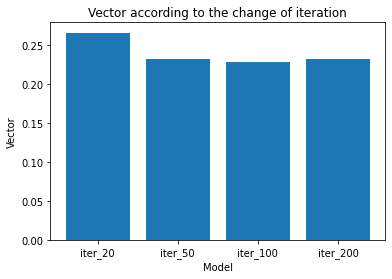

In [ ]:
plt.title('Vector according to the change of iteration')
plt.xlabel('Model')
plt.ylabel('Vector')
plt.bar(range(len(values_2)), values_2)
plt.xticks(range(len(labels_2)), labels_2)
plt.show()

- iteration을 높인다고 vector 값이 개선되지 않습니다. 

### 1.5 Conclusion

- 위에서 학습한 모델을 비슷한 영화를 뽑아보고 추천을 받아봅니다.

#### 1.5.1 Similar movies

- 입력한 하나의 영화와 비슷한 영화를 학습한 모델에서 뽑아봅니다.  
- 그 유명한 'Armageddon (1998)'입니다.
- 0.24의 vector 유사도를 보여준 als_model은 armageddon과 비슷한 어떤 영화를 뽑아낼지 알아봅니다.

In [ ]:
favorite_movie = 'Armageddon (1998)'
favorite_movie_id = title_to_id(favorite_movie)
print(favorite_movie_id)
my_movie_id = movie_to_idx[favorite_movie_id]
print(my_movie_id)
similar_movie = als_model.similar_items(my_movie_id, N=15)
similar_movie

1917
133


(array([ 133, 1058,  954,   86,  605,  564,  160,  895, 1190,  878,  125,
         432,   98,  630,  775], dtype=int32),
 array([0.9999999 , 0.73578185, 0.5645807 , 0.5621081 , 0.5527017 ,
        0.5504981 , 0.50633866, 0.50527686, 0.49026272, 0.47094873,
        0.46899095, 0.46353215, 0.45904455, 0.45411924, 0.44231752],
       dtype=float32))

In [ ]:
#movie_to_idx 를 뒤집어, index로부터 title을 얻는 dict를 생성합니다. 
idx_to_movie = {v:k for k,v in movie_to_idx.items()}
my_similar = [idx_to_movie[i] for i in similar_movie[0]]

In [ ]:
print(my_similar)

[1917, 1876, 1779, 1544, 316, 1831, 780, 1608, 185, 160, 1552, 1573, 1690, 2094, 1676]


- movie_id로 받았으니 title로 바꿔서 확인합니다.

In [ ]:
[id_to_title(i) for i in my_similar]

['Armageddon (1998)',
 'Deep Impact (1998)',
 'Sphere (1998)',
 'Lost World: Jurassic Park, The (1997)',
 'Stargate (1994)',
 'Lost in Space (1998)',
 'Independence Day (ID4) (1996)',
 'Air Force One (1997)',
 'Net, The (1995)',
 'Congo (1995)',
 'Con Air (1997)',
 'Face/Off (1997)',
 'Alien: Resurrection (1997)',
 'Rocketeer, The (1991)',
 'Starship Troopers (1997)']

- 내적이 1인 Armageddon (1998)을 기준으로 15개의 similar 목록을 만들었습니다.
- 어느정도 스타일이 비슷한 영화들이 뜹니다.  

- 위 과정을 함수화하여 다른 모델들은 어떤 차이가 있는지 비교합니다.

##### 1) Armageddon (1998)

- 각 모델별로 vector값이 다르므로 다 다르게 나올 것 같습니다.  
확인해봅니다.

- als_model(vector=0.24)

In [ ]:
similar_movies('Armageddon (1998)', als_model, 10)

Armageddon (1998)
Deep Impact (1998)
Sphere (1998)
Lost World: Jurassic Park, The (1997)
Stargate (1994)
Lost in Space (1998)
Independence Day (ID4) (1996)
Air Force One (1997)
Net, The (1995)
Congo (1995)


- als_model_1(vector=0.78)

In [ ]:
similar_movies('Armageddon (1998)', als_model_1, 10)

Armageddon (1998)
On Any Sunday (1971)
Back Stage (2000)
Benji the Hunted (1987)
Kids of the Round Table (1995)
Bluebeard (1944)
They Made Me a Criminal (1939)
Walking Dead, The (1995)
Zachariah (1971)
Big Bully (1996)


- als_model_3(vector=0.98)

In [ ]:
similar_movies('Armageddon (1998)', als_model_3, 10)

Armageddon (1998)
Broken Vessels (1998)
Relative Fear (1994)
Back Stage (2000)
Master Ninja I (1984)
Sweet Nothing (1995)
Talking About Sex (1994)
Stag (1997)
Tainted (1998)
I Don't Want to Talk About It (De eso no se habla) (1993)


- vector에 따라 결과가 매우 상이합니다.

##### 2) Shawshank Redemption, The (1994)

- 이번에는 Shawshank Redemption로 확인합니다.

- als_model(vector=0.24)

In [ ]:
similar_movies('Shawshank Redemption, The (1994)', als_model, 10)

Shawshank Redemption, The (1994)
Silence of the Lambs, The (1991)
Schindler's List (1993)
Pulp Fiction (1994)
Good Will Hunting (1997)
Fargo (1996)
GoodFellas (1990)
Saving Private Ryan (1998)
Dead Man Walking (1995)
Usual Suspects, The (1995)


- als_model_1(vector=0.78)

In [ ]:
similar_movies('Shawshank Redemption, The (1994)', als_model_1, 10)

Shawshank Redemption, The (1994)
Big Bully (1996)
Rage: Carrie 2, The (1999)
Blood, Guts, Bullets and Octane (1998)
Brother Minister: The Assassination of Malcolm X (1994)
Paris, France (1993)
Ulysses (Ulisse) (1954)
Match, The (1999)
Jerry & Tom (1998)
Children of the Corn IV: The Gathering (1996)


- als_model_3(vector=0.98)

In [ ]:
similar_movies('Shawshank Redemption, The (1994)', als_model_3, 10)

Shawshank Redemption, The (1994)
Relative Fear (1994)
Master Ninja I (1984)
Broken Vessels (1998)
Stag (1997)
Number Seventeen (1932)
Talking About Sex (1994)
Zero Kelvin (Kjærlighetens kjøtere) (1995)
Talk of Angels (1998)
Ripe (1996)


- 마찬가지입니다.  
각 모델별 vector 값에 따른 결과가 매우 다릅니다.

##### 3) Usual Suspects, The (1995)

- ratings에 5개를 올렸으니 전부 활용합니다.

- als_model(vector=0.24)

In [ ]:
similar_movies('Usual Suspects, The (1995)', als_model, 10)

Usual Suspects, The (1995)
Reservoir Dogs (1992)
Pulp Fiction (1994)
L.A. Confidential (1997)
Fargo (1996)
Seven (Se7en) (1995)
GoodFellas (1990)
Silence of the Lambs, The (1991)
Sixth Sense, The (1999)
Shawshank Redemption, The (1994)


- als_model_1(vector=0.78)

In [ ]:
similar_movies('Usual Suspects, The (1995)', als_model_1, 10)

Usual Suspects, The (1995)
Last Klezmer: Leopold Kozlowski, His Life and Music, The (1995)
Bittersweet Motel (2000)
Condition Red (1995)
Time of the Gypsies (Dom za vesanje) (1989)
Snowriders (1996)
Match, The (1999)
Regret to Inform (1998)
Snows of Kilimanjaro, The (1952)
Held Up (2000)


- als_model_3(vector=0.98)

In [ ]:
similar_movies('Usual Suspects, The (1995)', als_model_3, 10)

Usual Suspects, The (1995)
Master Ninja I (1984)
Relative Fear (1994)
Stag (1997)
Broken Vessels (1998)
Target (1995)
Sweet Nothing (1995)
Tainted (1998)
Number Seventeen (1932)
Talking About Sex (1994)


- 역시 위와 결과는 동일합니다.

#### 1.5.2 Likeable movies

- 이번에는 추천을 받아보겠습니다.
- 추천은 user의 id로 받으므로 한 번만 확인하는 것으로 진행합니다.

In [57]:
user = user_to_idx['JB']
# recommend에서는 user*item CSR Matrix를 받습니다.
movie_recommended = als_model.recommend(user, csr_data[user], N=10, filter_already_liked_items=True)
movie_recommended

(array([ 23, 128, 244,  51,  67, 246,  48, 336, 116, 280], dtype=int32),
 array([0.4985877 , 0.48052132, 0.4306749 , 0.40571484, 0.36224395,
        0.35710245, 0.328529  , 0.29263538, 0.273111  , 0.26979333],
       dtype=float32))

In [58]:
idx_to_movie = {v:k for k,v in movie_to_idx.items()}
my_recommended = [idx_to_movie[i] for i in movie_recommended[0]]

In [59]:
my_recommended

[527, 593, 296, 608, 1213, 1617, 2028, 1089, 1265, 1704]

In [60]:
[id_to_title(i) for i in my_recommended]

["Schindler's List (1993)",
 'Silence of the Lambs, The (1991)',
 'Pulp Fiction (1994)',
 'Fargo (1996)',
 'GoodFellas (1990)',
 'L.A. Confidential (1997)',
 'Saving Private Ryan (1998)',
 'Reservoir Dogs (1992)',
 'Groundhog Day (1993)',
 'Good Will Hunting (1997)']

- 함수로 확인해봅니다.

##### 1) model(vector=0.26)

In [62]:
recommended_movies('JB', als_model, 10)

Schindler's List (1993)
Silence of the Lambs, The (1991)
Pulp Fiction (1994)
Fargo (1996)
GoodFellas (1990)
L.A. Confidential (1997)
Saving Private Ryan (1998)
Reservoir Dogs (1992)
Groundhog Day (1993)
Good Will Hunting (1997)


In [69]:
movie_recommended = als_model.recommend(user, csr_data[user], N=10, filter_already_liked_items=True)
movie_recommended[1]

array([0.4985877 , 0.48052132, 0.4306749 , 0.40571484, 0.36224395,
       0.35710245, 0.328529  , 0.29263538, 0.273111  , 0.26979333],
      dtype=float32)

- 제가 좋아할 만한 리스트를 잘 뽑아준 것 같습니다.  
사실 영화가 너무 옛날 영화라 잘 모르겠습니다.

##### 2) model_1(vector=0.78)

In [63]:
recommended_movies('JB', als_model_1, 10)

Deep Impact (1998)
Twister (1996)
Pulp Fiction (1994)
Home Alone (1990)
Nutty Professor, The (1996)
Independence Day (ID4) (1996)
Homeward Bound: The Incredible Journey (1993)
Patch Adams (1998)
City Slickers II: The Legend of Curly's Gold (1994)
To Kill a Mockingbird (1962)


In [65]:
movie_recommended = als_model_1.recommend(user, csr_data[user], N=10, filter_already_liked_items=True)
movie_recommended[1]

array([0.16341497, 0.15564507, 0.1449492 , 0.14389941, 0.1325438 ,
       0.1272307 , 0.12363154, 0.11389615, 0.11375739, 0.11052623],
      dtype=float32)

- 제 취향에 잘 맞춘 것 같습니다.  
물론 너무 옛날 영화입니다...

##### 3) model_3(vector=0.98)

In [66]:
recommended_movies('JB', als_model_3, 10)

Home Alone 3 (1997)
Home Alone (1990)
Little Rascals, The (1994)
Twin Dragons (Shuang long hui) (1992)
Disturbing Behavior (1998)
City Slickers II: The Legend of Curly's Gold (1994)
Vampires (1998)
Blind Date (1987)
Freeway (1996)
Pocahontas (1995)


In [68]:
movie_recommended = als_model_3.recommend(user, csr_data[user], N=10, filter_already_liked_items=True)
movie_recommended[1]

array([0.07976422, 0.0572465 , 0.05666886, 0.05176216, 0.04823886,
       0.04302571, 0.04293301, 0.04078   , 0.03964026, 0.0396    ],
      dtype=float32)

- Home Alone 3 (1997) 라니요... 실망입니다.  
이번에 recommend에서 내적을 따로 뽑아본 이유가 여기에 있습니다.  
vector가 높다고 반드시 recommend를 잘하는건 아니라는 걸 확인할 수 있습니다.  
유사도가 많이 차이나는 것 같습니다.

#### 1.5.3 explain

- 이번에는 기여도를 살펴봅니다.  
기어도는 default 모델 하나만 살펴보고 넘어갑니다.

In [76]:
explain_movies('Silence of the Lambs, The (1991)', als_model)

0.4756407259467534
[(167, 0.32431462859783106), (259, 0.1288145117134676), (171, 0.036780945719554405), (1091, -0.0004595413649545704), (133, -0.013809818719145111)]


In [ ]:
mylist_idx = [167, 259, 171, 1091, 133]
idx_to_movie = {v:k for k,v in movie_to_idx.items()}
mylist_name_2 = [idx_to_movie[i] for i in mylist_idx]
[id_to_title(i) for i in mylist_name_2]

['Shawshank Redemption, The (1994)',
 'Usual Suspects, The (1995)',
 'Forrest Gump (1994)',
 'Home Alone 2: Lost in New York (1992)',
 'Armageddon (1998)']

- Silence of the Lambs, The (1991)의 내적은 0.4756 입니다.
- 추천해주는데 가장 영향이 큰 영화는 Shawshank Redemption, The (1994)로 0.3243입니다.
- 반대로 Armageddon (1998)은 유사도가 많이 떨어지는지 음수 값을 보입니다(-0.013809818719145111)  

### 1.6 Add Data

- 데이터가 너무 적습니다.  
너무 옛날 영화만 추천해 주는게 불만입니다!  
이번에는 데이터를 추가해서 살펴봅니다.

- Movielens에서 2021년도 데이터를 받습니다.  
ratings는 1.37GB, movie 정보가 있는 metadata는 17.1MB 입니다.

#### 1.6.1 Data load

In [9]:
rating_2_file_path='/gdrive/My Drive/Colab Notebooks/ml-2021/ratings.json'
movie_2_file_path='/gdrive/My Drive/Colab Notebooks/ml-2021/metadata_updated.json'

- 이걸 한번에 DataFrame으로 열면 너무 오랜 시간이 소요됩니다. 일단 json파일을 5줄만 불러서 살펴봅니다.

In [10]:
N = 5
with open(rating_2_file_path, encoding='utf-8') as myfile:
    head = [next(myfile) for x in range(N)]
print(len(head))
for l in head:
    print(l)

5
{"item_id": 5, "user_id": 997206, "rating": 3.0}

{"item_id": 10, "user_id": 997206, "rating": 4.0}

{"item_id": 13, "user_id": 997206, "rating": 4.0}

{"item_id": 17, "user_id": 997206, "rating": 5.0}

{"item_id": 21, "user_id": 997206, "rating": 4.0}



- 대충 key와 value를 볼 수 있습니다.
- json을 한 줄씩 읽어서 리스트 형태로 저장하게끔 만듭니다.

In [11]:
def yield_json(path):
    with open(path, 'r', encoding='utf-8-sig') as f: 
        for line in f:
            data = json.loads(line)
            yield data['item_id'],data['user_id'],data['rating']

- 함수를 이용해 ratings 안에 column name을 지정해서 넣습니다.

In [12]:
data = yield_json(rating_2_file_path)

In [13]:
ratings = pd.DataFrame.from_records(list(data), columns = ['item_id', 'user_id', 'rating'])

In [14]:
ratings.tail(5)

,item_id,user_id,rating
28490111,104211,187144,1.5
28490112,104243,187144,3.5
28490113,104374,187144,3.5
28490114,104841,187144,3.0
28490115,104913,187144,4.0


- 잘 들어왔습니다.
- 바로 metadata에도 적용합니다.

In [15]:
N = 5
with open(movie_2_file_path, encoding='utf-8') as myfile:
    head = [next(myfile) for x in range(N)]
print(len(head))
for l in head:
    print(l)

5
{"title": "Toy Story (1995)", "directedBy": "John Lasseter", "starring": "Tim Allen, Tom Hanks, Don Rickles, Jim Varney, John Ratzenberger, Wallace Shawn, Laurie Metcalf, John Morris, R. Lee Ermey, Annie Potts", "avgRating": 3.89146, "imdbId": "0114709", "item_id": 1}

{"title": "Jumanji (1995)", "directedBy": "Joe Johnston", "starring": "Jonathan Hyde, Bradley Pierce, Robin Williams, Kirsten Dunst", "avgRating": 3.26605, "imdbId": "0113497", "item_id": 2}

{"title": "Grumpier Old Men (1995)", "directedBy": "Howard Deutch", "starring": "Jack Lemmon, Walter Matthau, Ann-Margret , Sophia Loren", "avgRating": 3.17146, "imdbId": "0113228", "item_id": 3}

{"title": "Waiting to Exhale (1995)", "directedBy": "Forest Whitaker", "starring": "Angela Bassett, Loretta Devine, Whitney Houston, Lela Rochon", "avgRating": 2.86824, "imdbId": "0114885", "item_id": 4}

{"title": "Father of the Bride Part II (1995)", "directedBy": "Charles Shyer", "starring": "Steve Martin, Martin Short, Diane Keaton, 

In [16]:
def yield_json_2(path):
    with open(path, 'r', encoding='utf-8-sig') as f: 
        for line in f:
            data = json.loads(line)
            yield data['title'],data['directedBy'],data['starring'],data['avgRating'],data['imdbId'],data['item_id']

In [17]:
data = yield_json_2(movie_2_file_path)

In [18]:
movies = pd.DataFrame.from_records(list(data), 
                                   columns = ['title', 
                                              'directedBy',
                                              'starring',
                                              'avgRating',
                                              'imdbId',
                                              'item_id'
                                             ])

In [19]:
movies.tail(5)

,title,directedBy,starring,avgRating,imdbId,item_id
84656,The Tenth Level (1976),Charles S. Dubin,"William Shatner,Lynn Carlin,Ossie Davis,Viveca...",0.0,0075320,239306
84657,Nightmare (1974),William Hale,"Richard Crenna,Patty Duke,Vic Morrow,Arlene Go...",0.0,0071911,239308
84658,Pee Nak (2019),Phontharis Chotkijsadarsopon,"Chinawut Indracusin,Paisarnkulwong Vachiravit,...",0.0,8258474,239310
84659,Pee Nak 2 (2020),Phontharis Chotkijsadarsopon,"วชิรวิชญ์ ไพศาลกุลวงศ์,ภูริพรรธน์ เวชวงศาเตชาว...",0.0,11906412,239312
84660,The Making of the Philadelphia Eagles Cheerlea...,,"Steve Vaccariello,Barbara Zaun,Rob Babik,Brad ...",0.0,1533803,239314


- 역시 잘 들어왔습니다.

- merge로 데이터를 합쳐줍니다. item_id(movie_id)가 동일하므로 기준으로 잡습니다.

#### 1.6.2 Preprocess

In [20]:
ratings = pd.merge(ratings,movies, how='outer',on='item_id') 
orginal_data_size = len(ratings)

- column name을 정리합니다.

In [21]:
ratings.rename(columns={'rating':'count'}, inplace=True)

In [22]:
movies.rename(columns={'item_id':'movie_id'}, inplace=True)

In [23]:
ratings.rename(columns={'item_id':'movie_id'}, inplace=True)

- 나머지 과정은 데이터 수가 늘었을 뿐이지 위와 동일합니다.

In [24]:
# 3점 이상만 남깁니다.
ratings = ratings[ratings['count']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 28507818, filtered_data_size: 23350476
Ratio of Remaining Data is 81.91%


In [25]:
ratings.tail(5)

,movie_id,user_id,count,title,directedBy,starring,avgRating,imdbId
28490100,209523,788042.0,3.5,Silent Möbius 2 (1992),Yasunori Ide,"Gara Takashima,Hiromi Tsuru,Naoko Matsui,Masak...",3.50000,0160869
28490101,209527,788042.0,4.0,Great Planet Evil-Destroyer Dangaio (1987),Toshiki Hirano,"Akira Kamiya,Maya Okamoto,Mayumi Shou,Naoko Ma...",4.00000,0220381
28490104,200022,213110.0,4.5,A Thief in the Night (1972),Donald W. Thompson,"Patty Dunning,Mike Niday,Colleen Niday,Maryann...",2.62500,0070795
28490105,157617,35905.0,5.0,Desperate Teenage Lovedolls (1984),David Markey,Jennifer Schwartz,5.00000,0225499
28490113,200980,255423.0,3.0,"The Mayo Clinic, Faith, Hope and Science (2018)",Ken Burns,"Kevin Conway,Peter Coyote,Tom Hanks,Sam Waterston",3.16667,8946352


In [26]:
rating = ratings

In [27]:
ratings = ratings.drop(['directedBy','starring','imdbId'], axis=1)

In [28]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23350476 entries, 0 to 28490113
Data columns (total 5 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movie_id   int64  
 1   user_id    float64
 2   count      float64
 3   title      object 
 4   avgRating  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 1.0+ GB


In [29]:
ratings.tail(5)

,movie_id,user_id,count,title,avgRating
28490100,209523,788042.0,3.5,Silent Möbius 2 (1992),3.50000
28490101,209527,788042.0,4.0,Great Planet Evil-Destroyer Dangaio (1987),4.00000
28490104,200022,213110.0,4.5,A Thief in the Night (1972),2.62500
28490105,157617,35905.0,5.0,Desperate Teenage Lovedolls (1984),5.00000
28490113,200980,255423.0,3.0,"The Mayo Clinic, Faith, Hope and Science (2018)",3.16667


In [30]:
ratings['movie_id'].nunique()

59900

In [31]:
ratings['user_id'].nunique()

246098

- 약간의 전처리를 끝내고 다시 favorite list를 작성해 넣습니다.  
비교를 위해 위와 동일한 list를 작성합니다.

In [32]:
# favorite_title 5개 생성
favorite_title = ['Usual Suspects, The (1995)',
                  'Armageddon (1998)',
                  'Home Alone 2: Lost in New York (1992)',
                  'Shawshank Redemption, The (1994)',
                  'Forrest Gump (1994)']

# favorite_title -> favorite_id 변환 
favorite_id = [title_to_id(i) for i in favorite_title]

# user_id = 'JB', 5점 부여 
my_list = pd.DataFrame({'user_id': ['JB']*5, 'movie_id': favorite_id, 'count':[5]*5})

if not ratings.isin({'user_id':['JB']})['user_id'].any():  # user_id에 동일 id가 있는지 확인 후 추가
    ratings = ratings.append(my_list) 

In [33]:
ratings.tail(10)

,movie_id,user_id,count,title,avgRating
28490100,209523,788042.0,3.5,Silent Möbius 2 (1992),3.50000
28490101,209527,788042.0,4.0,Great Planet Evil-Destroyer Dangaio (1987),4.00000
28490104,200022,213110.0,4.5,A Thief in the Night (1972),2.62500
28490105,157617,35905.0,5.0,Desperate Teenage Lovedolls (1984),5.00000
28490113,200980,255423.0,3.0,"The Mayo Clinic, Faith, Hope and Science (2018)",3.16667
0,50,JB,5.0,NaN,NaN
1,1917,JB,5.0,NaN,NaN
2,2953,JB,5.0,NaN,NaN
3,318,JB,5.0,NaN,NaN
4,356,JB,5.0,NaN,NaN


- 인덱싱 과정을 진행합니다.

In [34]:
# 고유한 유저, 영화를 찾아내는 코드
user_unique = ratings['user_id'].unique()
movie_unique = ratings['movie_id'].unique()

# 유저, 영화 indexing 하는 코드
user_to_idx = {v:k for k,v in enumerate(user_unique)}
movie_to_idx = {v:k for k,v in enumerate(movie_unique)}

In [35]:
user_to_idx['JB']

246098

- 유저 수가 어마어마합니다.

In [36]:
temp_user_data = ratings['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(ratings):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    ratings['user_id'] = temp_user_data   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

# artist_to_idx을 통해 movie_id 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_movie_data = ratings['movie_id'].map(movie_to_idx.get).dropna()
if len(temp_movie_data) == len(ratings):
    print('movie id column indexing OK!!')
    ratings['movie_id'] = temp_movie_data
else:
    print('movie id column indexing Fail!!')

user_id column indexing OK!!
movie id column indexing OK!!


In [37]:
ratings.tail(10)

,movie_id,user_id,count,title,avgRating
28490100,59895,37069,3.5,Silent Möbius 2 (1992),3.50000
28490101,59896,37069,4.0,Great Planet Evil-Destroyer Dangaio (1987),4.00000
28490104,59897,200523,4.5,A Thief in the Night (1972),2.62500
28490105,59898,69886,5.0,Desperate Teenage Lovedolls (1984),5.00000
28490113,59899,69891,3.0,"The Mayo Clinic, Faith, Hope and Science (2018)",3.16667
0,11,246098,5.0,NaN,NaN
1,1339,246098,5.0,NaN,NaN
2,7127,246098,5.0,NaN,NaN
3,36,246098,5.0,NaN,NaN
4,43,246098,5.0,NaN,NaN


#### 1.6.3 Model

- model에 넣어줄 csr matrix를 만듭니다.

In [38]:
num_user = ratings['user_id'].nunique()
num_movie = ratings['movie_id'].nunique()

csr_data = csr_matrix((ratings['count'], (ratings['user_id'], ratings['movie_id'])), shape=(num_user, num_movie))
csr_data

<246099x59900 sparse matrix of type '<class 'numpy.float64'>'
	with 23163234 stored elements in Compressed Sparse Row format>

- model은 factor 500, iteration 20으로 설정했습니다.  

In [39]:
als_model_7 = AlternatingLeastSquares(factors=500, 
                                      regularization=0.01, 
                                      use_gpu=False, 
                                      iterations=20, 
                                      dtype=np.float32)

/usr/local/lib/python3.7/dist-packages/implicit/utils.py:27: UserWarning: OpenBLAS detected. Its highly recommend to set the environment variable 'export OPENBLAS_NUM_THREADS=1' to disable its internal multithreading
  "OpenBLAS detected. Its highly recommend to set the environment variable "


In [40]:
als_model_7.fit(csr_data)

  0%|          | 0/20 [00:00<?, ?it/s]

- 오래 걸립니다...

In [41]:
title_to_id('Armageddon (1998)')

1917

- list에 있는 Armageddon (1998)을 기준으로 vector를 찍어봅니다.

In [44]:
JB, armageddon = user_to_idx['JB'], movie_to_idx[1917]
JB_vector_7, armageddon_vector_7 = als_model_7.user_factors[JB], als_model_7.item_factors[armageddon]

In [45]:
np.dot(JB_vector_7, armageddon_vector_7)

0.8215139

- 너무 과하지도 않고 딱 좋다고 생각합니다.  

#### 1.6.4 Similar movies

- Armageddon (1998)과 비슷한 영화를 찾아봅니다.

In [53]:
favorite_movie = 'Armageddon (1998)'
favorite_movie_id = title_to_id(favorite_movie)
# print(favorite_movie_id)
my_movie_id = movie_to_idx[favorite_movie_id]
# print(my_movie_id)
similar_movie = als_model_7.similar_items(my_movie_id, N=15)
print(similar_movie[1])
similar_movie = similar_movie[0]

[1.0000001  0.41814145 0.35081217 0.2404133  0.23696342 0.23009084
 0.22854608 0.22131577 0.21994452 0.21947925 0.21736433 0.21673629
 0.21466516 0.21031013 0.2102491 ]


In [47]:
print(similar_movie)

[1339 1332 4479 1327 4744 5363 5360 1437  297 4783 4829 4480 7916 5367
 5890]


In [48]:
#movie_to_idx 를 뒤집어, index로부터 title을 얻는 dict를 생성합니다. 
idx_to_movie = {v:k for k,v in movie_to_idx.items()}
my_similar = [idx_to_movie[i] for i in similar_movie]

In [49]:
print(my_similar)

[1917, 1876, 1882, 1833, 1831, 1888, 1862, 2334, 1552, 2322, 2617, 1894, 1869, 2153, 2549]


In [50]:
[id_to_title(i) for i in my_similar]

['Armageddon (1998)',
 'Deep Impact (1998)',
 'Godzilla (1998)',
 'Mercury Rising (1998)',
 'Lost in Space (1998)',
 'Hope Floats (1998)',
 'Species II (1998)',
 'Siege, The (1998)',
 'Con Air (1997)',
 'Soldier (1998)',
 'Mummy, The (1999)',
 'Six Days Seven Nights (1998)',
 'Black Dog (1998)',
 'Avengers, The (1998)',
 'Wing Commander (1999)']

- 유사도가 높은 부분은 재난, 액션 쪽입니다.  
그 외 유사도가 낮은 부분에는 재난이나 액션 둘중 하나만 취하는 경우가 많습니다.

- 이번에는 Tenet (2020)을 기준으로 similar movies를 찍어봅니다.  
위에서 만든 함수를 이용합니다.

In [58]:
similar_movies('Tenet (2020)', als_model_7, 10)

[1.0000001  0.92641664 0.9080508  0.9072971  0.9025907  0.89513797
 0.89111215 0.887753   0.8813461  0.880124  ]
Tenet (2020)
Ad Astra (2019)
The Gentlemen (2020)
El Camino: A Breaking Bad Movie (2019)
Ford v. Ferrari (2019)
Bad Times at the El Royale (2018)
Palm Springs (2020)
Zombieland: Double Tap (2019)
Glass (2019)
Vice (2018)


- 유사도도 찍어봤습니다.  
테넷이 SF, 액션, 스릴러, 첩보, 드라마, 서스펜스 입니다.  
생각보다 유사한 영화들로만 뽑았습니다.  
주로 SF, 액션과 범죄, 어두운 느낌의 드라마 위주로 고른 것 같습니다.

- 최신 영화들이 나오니 훨씬 보기 좋습니다.

#### 1.6.5 Recommend_movies

- 이번에는 추천을 받아봅니다.

In [119]:
user = user_to_idx['JB']
# recommend에서는 user*item CSR Matrix를 받습니다.
movie_recommended = als_model_7.recommend(user, csr_data[user], N=15)
my_recommended = movie_recommended[0]

In [120]:
print(my_recommended)

[  76 1332 1621 4479  296 4829 4421 4767  146  297  249 4746 4765 4397
 4481]


In [121]:
idx_to_movie = {v:k for k,v in movie_to_idx.items()}
my_recommended_2 = [idx_to_movie[i] for i in my_recommended]

In [122]:
print(my_recommended_2)

[586, 1876, 3247, 1882, 1544, 2617, 2012, 2082, 1103, 1552, 266, 1918, 2054, 1923, 1911]


In [123]:
mylist = [id_to_title(i) for i in my_recommended_2]

In [124]:
print(*mylist[:], sep='\n') 

Home Alone (1990)
Deep Impact (1998)
Sister Act (1992)
Godzilla (1998)
Lost World: Jurassic Park, The (1997)
Mummy, The (1999)
Back to the Future Part III (1990)
Mighty Ducks, The (1992)
Rebel Without a Cause (1955)
Con Air (1997)
Legends of the Fall (1994)
Lethal Weapon 4 (1998)
Honey, I Shrunk the Kids (1989)
There's Something About Mary (1998)
Dr. Dolittle (1998)


- google에 검색해보니 제가 좋아할 만한 영화들입니다.  
추천 목록에 'Home Alone 3'가 없어서 너무 좋습니다.

#### 1.6.6 New list

- 최신 영화 목록을 구해왔는데 써봐야겠습니다.  
좋아하는 영화 목록을 최신화합니다.

In [32]:
# favorite_title 5개 생성
favorite_title = ['Tenet (2020)',
                  'Interstellar (2014)',
                  'Dark Knight, The (2008)',
                  'Lord of the Rings: The Two Towers, The (2002)',
                  'Inception (2010)']    

# favorite_title -> favorite_id 변환 
favorite_id = [title_to_id(i) for i in favorite_title]

# user_id = 'JB', 5점 부여 
my_list = pd.DataFrame({'user_id': ['Chae']*5, 'movie_id': favorite_id, 'count':[5]*5})

if not ratings.isin({'user_id':['Chae']})['user_id'].any():  # user_id에 동일 id가 있는지 확인 후 추가
    ratings = ratings.append(my_list) 

- 과정은 위와 동일하므로 빠르게 넘어갑니다.

In [33]:
ratings.tail(10)

,movie_id,user_id,count,title,avgRating
28490100,209523,788042.0,3.5,Silent Möbius 2 (1992),3.50000
28490101,209527,788042.0,4.0,Great Planet Evil-Destroyer Dangaio (1987),4.00000
28490104,200022,213110.0,4.5,A Thief in the Night (1972),2.62500
28490105,157617,35905.0,5.0,Desperate Teenage Lovedolls (1984),5.00000
28490113,200980,255423.0,3.0,"The Mayo Clinic, Faith, Hope and Science (2018)",3.16667
0,217465,Chae,5.0,NaN,NaN
1,109487,Chae,5.0,NaN,NaN
2,58559,Chae,5.0,NaN,NaN
3,5952,Chae,5.0,NaN,NaN
4,79132,Chae,5.0,NaN,NaN


In [34]:
# 고유한 유저, 영화를 찾아내는 코드
user_unique = ratings['user_id'].unique()
movie_unique = ratings['movie_id'].unique()

# 유저, 영화 indexing 하는 코드
user_to_idx = {v:k for k,v in enumerate(user_unique)}
movie_to_idx = {v:k for k,v in enumerate(movie_unique)}

In [35]:
user_to_idx['Chae']

246098

In [36]:
temp_user_data = ratings['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(ratings):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    ratings['user_id'] = temp_user_data   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

# artist_to_idx을 통해 movie_id 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_movie_data = ratings['movie_id'].map(movie_to_idx.get).dropna()
if len(temp_movie_data) == len(ratings):
    print('movie id column indexing OK!!')
    ratings['movie_id'] = temp_movie_data
else:
    print('movie id column indexing Fail!!')

user_id column indexing OK!!
movie id column indexing OK!!


In [37]:
ratings.tail(10)

,movie_id,user_id,count,title,avgRating
28490100,59895,37069,3.5,Silent Möbius 2 (1992),3.50000
28490101,59896,37069,4.0,Great Planet Evil-Destroyer Dangaio (1987),4.00000
28490104,59897,200523,4.5,A Thief in the Night (1972),2.62500
28490105,59898,69886,5.0,Desperate Teenage Lovedolls (1984),5.00000
28490113,59899,69891,3.0,"The Mayo Clinic, Faith, Hope and Science (2018)",3.16667
0,15713,246098,5.0,NaN,NaN
1,7094,246098,5.0,NaN,NaN
2,6326,246098,5.0,NaN,NaN
3,4621,246098,5.0,NaN,NaN
4,3133,246098,5.0,NaN,NaN


In [38]:
num_user = ratings['user_id'].nunique()
num_movie = ratings['movie_id'].nunique()

csr_data = csr_matrix((ratings['count'], (ratings['user_id'], ratings['movie_id'])), shape=(num_user, num_movie))
csr_data

<246099x59900 sparse matrix of type '<class 'numpy.float64'>'
	with 23163234 stored elements in Compressed Sparse Row format>

- 이번에는 GPU 옵션을 True로 설정합니다.  
- factor는 500, iteration은 20입니다.
- 문제는 속도는 매우 빠른데... error가 빈번하게 발생하며, vector 값을 기존의 방법대로 찍을 수 없어서 확인을 못합니다.

In [39]:
als_model_8 = AlternatingLeastSquares(factors=500, 
                                      regularization=0.01, 
                                      use_gpu=True, 
                                      iterations=20, 
                                      dtype=np.float32)

In [40]:
als_model_8.fit(csr_data)

  0%|          | 0/20 [00:00<?, ?it/s]

In [121]:
user = user_to_idx['Chae']
# recommend에서는 user*item CSR Matrix를 받습니다.
movie_recommended = als_model_8.recommend(user, csr_data[user], N=10)

- 함수를 이용해 10개만 추천 받아봅니다.

In [125]:
recommended_movies('Chae', als_model_8, 10)

Lord of the Rings: The Return of the King, The (2003)
Lord of the Rings: The Fellowship of the Ring, The (2001)
Dark Knight Rises, The (2012)
The Imitation Game (2014)
The Martian (2015)
Gone Girl (2014)
Batman Begins (2005)
Edge of Tomorrow (2014)
Arrival (2016)
Ex Machina (2015)


- 딱 제가 좋아하는 영화들만 모여있네요.  
- 90년대 영화에서 벗어났습니다.
싹 다 제 취향입니다...

#### 1.6.7 Similar_users

- 이번에는 저와 비슷한 user를 찾아봅니다.

In [126]:
user = user_to_idx['Chae']
similar_users = als_model_8.similar_users(user, N=10, filter_users=None, users=None)
print(similar_users)

(array([246098, 242194, 242212, 240839, 239962, 242199, 244223, 242236,
       225203, 242196], dtype=int32), array([1.0000001 , 0.84673256, 0.81196904, 0.8040556 , 0.74198925,
       0.7319381 , 0.7207067 , 0.71995497, 0.6984868 , 0.6981419 ],
      dtype=float32))


- 0.6829의 내적을 나타내는 240839번 user가 있습니다.  
참고로 246098은 제 번호 입니다.

In [127]:
similar_users = similar_users[0]

In [128]:
idx_to_user = {v:k for k,v in user_to_idx.items()}
my_similar_users = [idx_to_user[i] for i in similar_users]

- index에서 user_id를 뽑아봅니다.

In [129]:
print(my_similar_users)

['Chae', 335571.0, 730980.0, 278693.0, 830853.0, 410314.0, 289246.0, 172568.0, 846390.0, 171368.0]


- 어짜피 ratings에 indexing을 진행했으므로 idx 값을 그대로 넣어줍니다.

In [130]:
user_data = ratings.loc[ratings['user_id'].isin([242194])]
print(user_data)

          movie_id  user_id  count  \
16177819      3133   242194    5.0   
18717074      4591   242194    5.0   
25197929      7094   242194    4.5   

                                                      title  avgRating  
16177819                                   Inception (2010)    4.17404  
18717074  Lord of the Rings: The Fellowship of the Ring,...    4.09616  
25197929                                Interstellar (2014)    4.12967  


- 딱 제 favorite list와 겹치게 봐서 3편이지만 유사도가 제일 높습니다.

In [133]:
user_data = ratings.loc[ratings['user_id'].isin([242212])]
print(user_data)

          movie_id  user_id  count  \
16181860      3133   242212    4.5   
19206491      4662   242212    5.0   
23703882      6326   242212    5.0   

                                                      title  avgRating  
16181860                                   Inception (2010)    4.17404  
19206491  Lord of the Rings: The Return of the King, The...    4.10393  
23703882                            Dark Knight, The (2008)    4.18379  


- 마찬가지입니다.

In [134]:
user_data = ratings.loc[ratings['user_id'].isin([240839])]
print(user_data)

          movie_id  user_id  count  \
14151341      2043   240839    4.5   
16195325      3133   240839    5.0   
16918938      4129   240839    3.5   
18732048      4591   240839    5.0   
18974797      4621   240839    5.0   
19218841      4662   240839    5.0   
23715522      6326   240839    5.0   
25210442      7094   240839    5.0   
26214167      8474   240839    4.5   

                                                      title  avgRating  
14151341                         Catch Me If You Can (2002)    3.94781  
16195325                                   Inception (2010)    4.17404  
16918938                                The Big Sick (2017)    3.81970  
18732048  Lord of the Rings: The Fellowship of the Ring,...    4.09616  
18974797      Lord of the Rings: The Two Towers, The (2002)    4.07515  
19218841  Lord of the Rings: The Return of the King, The...    4.10393  
23715522                            Dark Knight, The (2008)    4.18379  
25210442                           

- 저랑 취향이 비슷합니다 'Blade Runner 2049'도 겁나 좋아합니다...

In [136]:
user_data = ratings.loc[ratings['user_id'].isin([239962])]
print(user_data)

          movie_id  user_id  count  \
12903688      1697   239962    4.5   
16190901      3133   239962    4.0   
18728388      4591   239962    4.0   
18971347      4621   239962    3.0   
19214857      4662   239962    4.0   
23711891      6326   239962    3.5   

                                                      title  avgRating  
12903688                                   Gladiator (2000)    3.96406  
16190901                                   Inception (2010)    4.17404  
18728388  Lord of the Rings: The Fellowship of the Ring,...    4.09616  
18971347      Lord of the Rings: The Two Towers, The (2002)    4.07515  
19214857  Lord of the Rings: The Return of the King, The...    4.10393  
23711891                            Dark Knight, The (2008)    4.18379  


- 비교해서 보니까 재미있네요.

In [137]:
user_data = ratings.loc[ratings['user_id'].isin([242199])]
print(user_data)

          movie_id  user_id  count  \
16178966      3133   242199    5.0   
16735310      3821   242199    3.5   
16781730      3936   242199    4.0   
18718136      4591   242199    5.0   
18961917      4621   242199    4.5   
19203816      4662   242199    5.0   
25198993      7094   242199    5.0   

                                                      title  avgRating  
16178966                                   Inception (2010)    4.17404  
16735310                          The Imitation Game (2014)    4.01275  
16781730                                 The Martian (2015)    4.03858  
18718136  Lord of the Rings: The Fellowship of the Ring,...    4.09616  
18961917      Lord of the Rings: The Two Towers, The (2002)    4.07515  
19203816  Lord of the Rings: The Return of the King, The...    4.10393  
25198993                                Interstellar (2014)    4.12967  


- 마션도 겁나 좋아합니다.

## 2. Retrospect

##### 1) Vector
- vector의 차이에 따른 추천을 비교해봤습니다.  
vector 값이 무조건 크다고 해서 추천을 잘해주는 건 아닌 것 같습니다.  
일종의 over_fitting인 것 같은 느낌을 많이 받았는데 작성한 favorite list를 제외하고 나머지 값들과는 유사도가 매우 차이 났습니다.

##### 2) Json file
- 그냥 json파일 불러오면 끝이 아니라는 걸 깨달았습니다.  
특히 이번처럼 GB 단위로 넘어가는 json파일은 한 줄 한 줄 정성을 다하지 않으면... 커널이 못 버팁니다.  
불러오는 것까지는 어떻게 했다고 한들 model도 학습해야 하니까요.  
다른건 몰라도 Json 파일 여는 법은 제대로 배워갑니다.  
꼭 함수로 처리해 한줄 한줄 정성을 다합시다.

##### 3) Data
- Data는 많아야 합니다.  
데이터가 적을 수록 재미 없습니다. 시간이 걸리더라도 많은 데이터로 model을 돌려야 기분이 좋습니다.  
시간이 허락하는 한 최대한 많은 데이터를 가져다가 사용해봐야겠습니다.

##### 4) implicit
- implicit 패키지는 생각보다 관리를 안 하는 것 같습니다. update에서 변화가 있지만 설명이 부실하다거나  
사람들이 많이 사용하지 않아 오류에 대한 논의도 별로 없는 것 같습니다.  
비슷한 기능을 가진 패키지가 있다면 대중적인 부분을 따지고 사용하는 것도 좋겠습니다.

##### 5) Version
- 매번 version 문제는 한번씩은 터집니다. downgrade도 불가능하고,  
사용하는 version에 따라 matrix를 transpose 해야하는 경우도 생깁니다.  
output의 array도 달라 생각보다 고생했습니다.

##### 6) Library
- Amazon의 Surprise이나 LightFM, Buffalo, Spotlight 등의 라이브러리를 써보고 싶었습니다만, 시간이 없어 넘어갑니다.  
다음에는 여러 라이브러리를 비교해보려 합니다.

## 3. References

- 아래의 사이트에서 많은 도움을 받았습니다.

##### 1) MovieLens
- https://grouplens.org/datasets/movielens/

##### 2) Implicit(0.5.0)
- (0.5.0)
- https://benfred.github.io/implicit/index.html
- https://github.com/benfred/implicit/issues/535

- (0.4.8)
- https://implicit.readthedocs.io/en/latest/quickstart.html

##### 3) Surprise
- https://surprise.readthedocs.io/en/stable/index.html

##### 4) LightFM
- https://making.lyst.com/lightfm/docs/home.html

##### 5) Buffalo
- https://buffalo-recsys.readthedocs.io/en/latest/index.html

##### 6) Spotlight
- https://maciejkula.github.io/spotlight/index.html